In [1]:
# imports 
import emp_preprocessing as ep
import emp_fake_data as ef
import emp_metrics as em
import networkx as nx
import functions as fct
import numpy as np
import pandas as pd
import parameters as par
import os
import graphics as gx
import data_mapping as dm

# parameters
path = "./results/empirical_results/"
plot_period=1000

# 1 data preprocessing

## 1.1  load input data from ECB databases

In [ ]:
# get df_mmsr unsecured (used for deposits time series)
df_mmsr_unsecured = pd.read_stata("path-to-stata") # ajouter le path

# get df_mmsr secured (used for transaction view)
df_mmsr_secured = pd.read_stata("path-to-stata") # ajouter le path

# get the mmsr transaction view directly
df_exposures = pd.read_stata("path-to-stata") # ajouter le path

# get finrep data
df_finrep = pd.read_stata("path-to-stata") # ajouter le path
df_finrep.rename(columns=dm.dic_finrep_columns, inplace=True) # change the columns names 

## 1.2 build fake data (optional)

In [ ]:
nb_lines = int(1e6) # 1 million lines

# get df_mmsr unsecured (used for deposits time series)
df_mmsr_unsecured = ef.get_df_mmsr_unsecured(nb_tran=nb_lines,freq="10min")

# get df_mmsr secured (used for transaction view)
df_mmsr_secured = ef.get_df_mmsr_secured(nb_tran=nb_lines,freq="10min", holidays=dm.holidays)

# get the mmsr exposure view directly
df_exposures = ef.get_df_exposures(lines=int(1e5),freq="5h")

# build fake finrep data
df_finrep = ef.get_df_finrep()

## 1.3 preprocessing

In [3]:
# get dic reverse repo exp adj history
dic_rev_repo_exp_adj = ep.get_dic_rev_repo_exp_adj_from_exposures(df_exposures=df_exposures,path=path, plot_period=plot_period)

# get aggregated adjency matrices
dic_arr_binary_adj = ep.get_dic_arr_binary_adj(dic_rev_repo_exp_adj=dic_rev_repo_exp_adj,path=path, plot_period=plot_period)

# get dic dashed trajectory 
dic_dashed_trajectory = ep.get_dic_dashed_trajectory(df_finrep)

get dic_rev_repo_exp_adj


100%|██████████| 100000/100000 [00:32<00:00, 3032.56it/s]


get dic_arr_binary_adj
get dic_dashed_trajectory


In [4]:
# pickle (faster)
dic_arr_binary_adj = ep.load_dic_arr_binary_adj(path=path)
dic_rev_repo_exp_adj = ep.load_dic_rev_repo_exp_adj(path=path)
dic_dashed_trajectory = ep.get_dic_dashed_trajectory(df_finrep)

get dic_dashed_trajectory


# 2 metrics measurement

In [4]:
os.makedirs(f"{path}accounting_view/", exist_ok=True)

### 2.1.2 accounting items

#### A - static, distribution across banks, at several point in time 

In [ ]:
days = list(dic_rev_repo_exp_adj.keys())
plot_days = fct.list_intersection(days, dic_dashed_trajectory.keys())
bank_items = list(dic_dashed_trajectory.values())[0].columns

# get df_powerlaw
df_powerlaw = em.get_powerlaw(
            dic_dashed_trajectory=dic_dashed_trajectory,
            days=days,
            plot_days=plot_days,
            plot_period=plot_period,
            path=f"{path}accounting_view/power_law/"
        )

# plot each powerlaw charts 
gx.plot_powerlaw(
            df_network_trajectory=df_powerlaw,
            days=days,
            plot_period=plot_period,
            path=f"{path}accounting_view/",
            plot_days=plot_days,
        )

# plot p-values across time 
gx.plot_network_trajectory(
                df=df_powerlaw,
                cols=[f"powerlaw p-value {bank_item}"  for bank_item in bank_items],
                file_name=f"{path}accounting_view/power_law/powerlaw_pvalue.pdf",
            )

# plot alpha of power laws across time 
gx.plot_network_trajectory(
                df=df_powerlaw,
                cols=[f"powerlaw alpha {bank_item}"  for bank_item in bank_items],
                file_name=f"{path}accounting_view/power_law/powerlaw_alpha.pdf",
            )

#### B - dynamic, distribution across time

In [ ]:
# distribution of deposits relative variation across time for each single bank
df_deposits_variations_by_bank = ep.get_df_deposits_variations_by_bank(df_mmsr_unsecured, dic_dashed_trajectory, f"{path}/accounting_view/deposits/")

df = df_deposits_variations_by_bank[df_deposits_variations_by_bank>0]
em.run_n_plot_powerlaw(df,f"{path}accounting_view/deposits/per_bank/positive/")

df = -df_deposits_variations_by_bank[df_deposits_variations_by_bank<0]
em.run_n_plot_powerlaw(df,f"{path}accounting_view/deposits/per_bank/negative/")

#### C - mixed view across time and banks

In [ ]:
# distribution of deposits relative variation across time for each single bank
df_mmsr_unsecured = ef.get_df_mmsr_unsecured(10000,freq="10min")
df_deposits_variations = ep.get_df_deposits_variation(df_mmsr_unsecured, dic_dashed_trajectory, f"{path}/accounting_view/deposits/")

df = df_deposits_variations[df_deposits_variations>0]
em.run_n_plot_powerlaw(df,f"{path}accounting_view/deposits/positive/")

df = -df_deposits_variations[df_deposits_variations<0]
em.run_n_plot_powerlaw(df,f"{path}accounting_view/deposits/negative/")

## 2.2. exposure view

In [4]:
os.makedirs(f"{path}exposure_view/", exist_ok=True)

### 2.2.1 jaccard

In [11]:
days = list(dic_rev_repo_exp_adj.keys())

# get jaccard
df_jaccard = em.get_rev_repo_exposure_stats(dic_arr_binary_adj, days, path=path)
gx.plot_network_trajectory(
            df=df_jaccard,
            cols=df_jaccard.columns,
            file_name=f"{path}exposure_view/jaccard_index.pdf")

get jaccard


100%|██████████| 20833/20833 [00:04<00:00, 4288.08it/s]


### 2.2.2 density

In [12]:
days = list(dic_rev_repo_exp_adj.keys())

# get density
df_density = em.get_density(dic_arr_binary_adj, days, path=path)
gx.plot_network_trajectory(
            df=df_density,
            cols=df_density.columns,
            file_name=f"{path}exposure_view/network_density.pdf",
        )

get density


100%|██████████| 20833/20833 [00:04<00:00, 4385.73it/s]


### 2.2.3 degree distribution  (static)

In [13]:
days = list(dic_rev_repo_exp_adj.keys())

# get degree distribution
dic_in_degree, dic_out_degree, dic_degree = em.get_degree_distribution(dic_arr_binary_adj, path=f"{path}exposure_view/degree_distribution/")
gx.plot_degree_distribution(dic_in_degree,
    dic_out_degree,
    days,
    plot_period,
    f"{path}exposure_view/degree_distribution/")


get degree distribution


100%|██████████| 20834/20834 [00:10<00:00, 1921.16it/s]


### 2.2.4 degree stats

In [14]:
days = list(dic_rev_repo_exp_adj.keys())

# get av. degree
df_degree_stats = em.get_degree_stats(dic_degree, days, path=path)
gx.plot_network_trajectory(
            df=df_degree_stats,
            cols=df_degree_stats.columns,
            file_name=f"{path}exposure_view/degree_stats.pdf",
        )

get degree stats


100%|██████████| 20833/20833 [00:15<00:00, 1357.74it/s]


### 2.2.5 degree per asset

In [15]:
days = list(dic_rev_repo_exp_adj.keys())
bank_ids = list(dic_rev_repo_exp_adj.values())[0].index

# select the days and banks (common between the 2 lists)
finrep_days = list(df_finrep["date"])
finrep_bank_ids = list(set(df_finrep["lei"]))
plot_days = fct.list_intersection(days, finrep_days)

# plot
gx.plot_degree_per_asset(
    dic_dashed_trajectory,
    dic_degree,
    bank_ids,
    days,
    plot_period,
    f"{path}exposure_view/degree_per_asset/",
    plot_days=plot_days,
    finrep_bank_ids=finrep_bank_ids)

### 2.2.6 network plots (static)

In [16]:
days = list(dic_rev_repo_exp_adj.keys())
bank_ids = list(list(dic_rev_repo_exp_adj.values())[0].index)
arr_rev_repo_exp_adj = ep.convert_dic_to_array(dic_rev_repo_exp_adj)
plot_days = fct.list_intersection(days, dic_dashed_trajectory.keys())

# plot the reverse repo network
gx.plot_weighted_adj_network(
    arr_rev_repo_exp_adj,
    dic_dashed_trajectory,
    days,
    plot_period,
    f"{path}exposure_view/weighted_adj_network/",
    "reverse repo",
    bank_ids=bank_ids,
    plot_days=plot_days,
)

### 2.2.6 core periphery (static)

In [ ]:
arr_rev_repo_exp_adj = ep.convert_dic_to_array(dic_rev_repo_exp_adj)
days = list(dic_rev_repo_exp_adj.keys())

# get df_cpnet
df_cpnet = em.get_cpnet(
                dic_arr_binary_adj=dic_arr_binary_adj,
                arr_rev_repo_exp_adj=arr_rev_repo_exp_adj,
                days=days,
                plot_period=plot_period,
                path=f"{path}exposure_view/core-periphery/",
            )

# Plot the core-periphery struture
gx.plot_cpnet(
                df_network_trajectory=df_cpnet,
                dic_arr_binary_adj=dic_arr_binary_adj,
                arr_rev_repo_exp_adj=arr_rev_repo_exp_adj,
                days=days,
                plot_period=plot_period,
                path=f"{path}exposure_view/",
            )

# # read csv (faster)
# df_cpnet = pd.read_csv(f"{path}exposure_view/core-periphery/df_cpnet.csv", index_col=0)
# df_cpnet.index = pd.to_datetime(df_cpnet.index)

# plot the time evolution of p-values for each aggregation level
for fig in par.figs_cpnet_pvalues:
    gx.plot_network_trajectory(
            df=df_cpnet,
            cols=fig[1],
            file_name=f"{path}{fig[0]}.pdf",
        )

## 2.3 transaction view

In [ ]:
os.makedirs(f"{path}transaction_view/", exist_ok=True)

### 2.3.1 av network

**MMSR reporting instructions for evergreen repos**

The reporting of evergreen repos is defined by the MMSR reporting instruction, paragraph 3.1 https://www.ecb.europa.eu/stats/money/mmss/shared/files/MMSR-Reporting_instructions.pdf

Evergreen are reported with the notice period defined as the maturity date and rolled over every day (reporting a new line in MMSR each day) until the product is cancelled.

To detect an evergreen we flag all transactions that are repeted across several days with the exact same counterparties, nominal amount and tenor.

In [5]:
# get df_rev_repo_trans
df_rev_repo_trans = ep.get_df_rev_repo_trans(df_mmsr_secured,holidays=dm.holidays, path=path)
df_rev_repo_trans 

,owner_bank_id,bank_id,trans_id,amount,start_step,tenor,status
0,bank_1,bank_6,0,85.795266,0,13,False
1,bank_2,fund_1,1,1.903799,0,30,False
2,bank_6,bank_10,2,32.905824,0,17,False
4,bank_3,bank_1,4,12.285778,0,34,False
6,bank_8,bank_10,6,78.285520,0,4,False
...,...,...,...,...,...,...,...
1618137,bank_9,fund_4,"[52667, 52667, 52667, 52667, 52667, 52667, 526...",99.955551,260,18,False
1618138,bank_9,fund_4,"[52667, 52667, 52667, 52667, 52667, 52667, 526...",99.955551,257,18,False
1618139,bank_9,fund_4,"[52667, 52667, 52667, 52667, 52667, 52667, 526...",99.955551,261,18,False
1618140,bank_9,fund_4,"[52667, 52667, 52667, 52667, 52667, 52667, 526...",99.955551,257,18,False


In [9]:
days = list(dic_rev_repo_exp_adj.keys())[:200]
df_transaction_stats = em.get_transaction_stats(
            df_rev_repo_trans=df_rev_repo_trans,
            extension=" av. network",
            days=days,
            path=f"{path}transaction_view/",
        )


# plot the time evolution of the av network trans level metrics
for fig in [par.fig_repo_transactions_maturity_av_network, par.fig_repo_transactions_notional_av_network, par.fig_number_repo_transactions_av_network]:
    gx.plot_network_trajectory(
            df=df_transaction_stats,
            cols=fig[1],
            file_name=f"{path}{fig[0]}.pdf",
        )


get transaction stats av. network


100%|██████████| 199/199 [00:53<00:00,  3.71it/s]


# 3 tools

## 3.1 examples of density / histogram in log - log

### pareto law

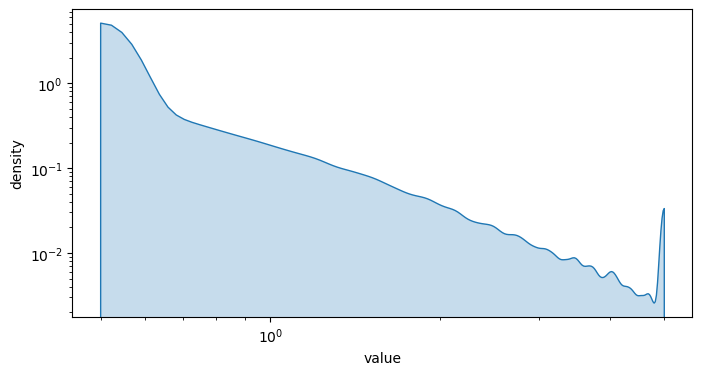

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate random data
x = np.random.pareto(3,size=100000)

# Compute the absolute value and sign of the data
abs_x = np.abs(x)
sign_x = np.sign(x)

# Set up the figure
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the KDE on a log scale with the transformed data
sns.kdeplot(x.clip(0.5,5), ax=ax, cut=0, fill=True)
ax.set_xscale('log')

# Set the y-axis to log scale
ax.set_yscale('log')

# Set axis labels
ax.set_xlabel('value')
ax.set_ylabel('density')

# Show the plot
plt.show()

### student law

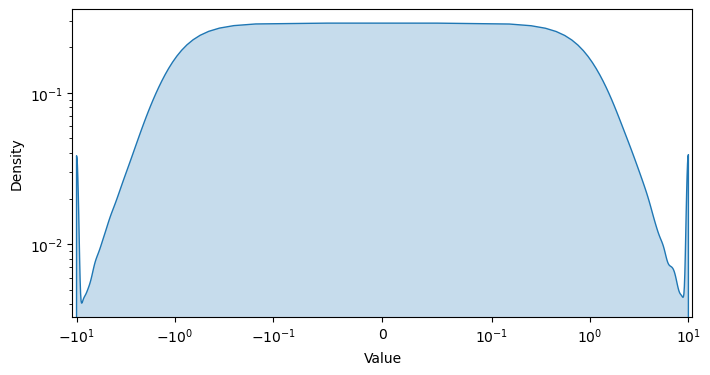

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate random data
x = np.random.standard_t(1,size=100000)

# Compute the absolute value and sign of the data
abs_x = np.abs(x)
sign_x = np.sign(x)

# Set up the figure
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the KDE on a log scale with the transformed data
sns.kdeplot(x.clip(-10,10), ax=ax, fill=True, cut=0)
ax.set_xscale('symlog', linthresh=0.1)

# Set the y-axis to log scale
ax.set_yscale('log')

# Set axis labels
ax.set_xlabel('Value')
ax.set_ylabel('Density')

# Show the plot
plt.show()

## 3.2 multiple histogram on the same plot

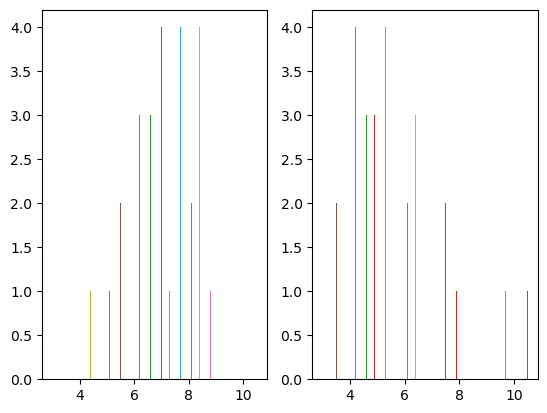

In [24]:
from matplotlib import pyplot as plt

fig, (ax1,ax2) = plt.subplots(1,2)
pos = 0
width = 0.2
for  i in range(10):
    binary_adj = np.random.randint(0,2,(10,10))
    bank_network = nx.from_numpy_array(
                binary_adj,
                parallel_edges=False,
                create_using=nx.DiGraph,
            )  # first define a networkx object.
    ar_in_degree = np.array(bank_network.in_degree())[:,1]
    hist = np.unique(ar_in_degree, return_counts=True)
    ax1.bar(hist[0] + pos, hist[1], width=0.01)
    ax2.bar(hist[0] + pos, hist[1], width=0.01)
    pos = pos +width +0.1



## 3.3 power low fitting

Calculating best minimal value for power law fit
/mnt/live/user/vlecoz/conda_env/money_markets/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


2.739898963091264
0.850901796570982


<AxesSubplot: >

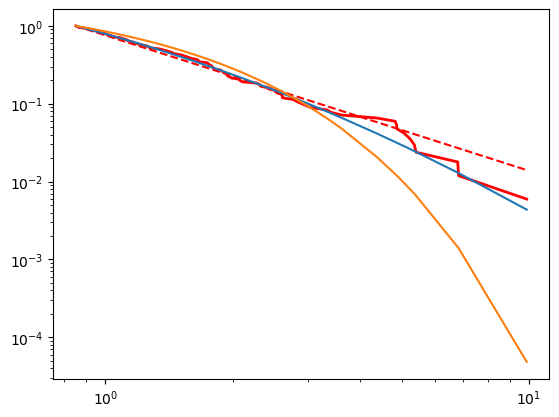

In [25]:
# fitting
import powerlaw
import numpy as np
sr_data = np.random.pareto(3,size=1000) # data can be list or numpy array
powerlaw_fit = powerlaw.Fit(sr_data)
print(powerlaw_fit.power_law.alpha)
print(powerlaw_fit.power_law.xmin)
R, p = powerlaw_fit.distribution_compare('power_law', 'exponential')
fig2 = powerlaw_fit.plot_ccdf(color = "r", linewidth = 2)
powerlaw_fit.power_law.plot_ccdf(color = "r", linestyle = "--", ax = fig2)
powerlaw_fit.lognormal.plot_ccdf(ax=fig2)
powerlaw_fit.exponential.plot_ccdf(ax=fig2)

## 3.4 build the calendar

In [ ]:
from workalendar.europe import EuropeanCentralBank

# build the list of holidays
holidays = []
for year in range(2000,2023):
    holidays = holidays + EuropeanCentralBank().holidays(year)

# reformating into a list
holidays = [tuple_day[0] for tuple_day in holidays]


[datetime.date(2000, 1, 1),
 datetime.date(2000, 4, 21),
 datetime.date(2000, 4, 24),
 datetime.date(2000, 5, 1),
 datetime.date(2000, 12, 25),
 datetime.date(2000, 12, 26),
 datetime.date(2001, 1, 1),
 datetime.date(2001, 4, 13),
 datetime.date(2001, 4, 16),
 datetime.date(2001, 5, 1),
 datetime.date(2001, 12, 25),
 datetime.date(2001, 12, 26),
 datetime.date(2002, 1, 1),
 datetime.date(2002, 3, 29),
 datetime.date(2002, 4, 1),
 datetime.date(2002, 5, 1),
 datetime.date(2002, 12, 25),
 datetime.date(2002, 12, 26),
 datetime.date(2003, 1, 1),
 datetime.date(2003, 4, 18),
 datetime.date(2003, 4, 21),
 datetime.date(2003, 5, 1),
 datetime.date(2003, 12, 25),
 datetime.date(2003, 12, 26),
 datetime.date(2004, 1, 1),
 datetime.date(2004, 4, 9),
 datetime.date(2004, 4, 12),
 datetime.date(2004, 5, 1),
 datetime.date(2004, 12, 25),
 datetime.date(2004, 12, 26),
 datetime.date(2005, 1, 1),
 datetime.date(2005, 3, 25),
 datetime.date(2005, 3, 28),
 datetime.date(2005, 5, 1),
 datetime.date(200